In [1]:
import os
import numpy as np
import mne
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu, ranksums, wilcoxon
from scipy import signal
from statsmodels.stats.multitest import multipletests

###############################################################################
#                     (A) User Parameters & Frequency Bands                   #
###############################################################################
# Define your frequency bands (you can modify or add more)
freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta":  (12, 30),
    "Gamma": (30, 45)
}

# Define scalp region indices (adjust if your channel naming differs)
# We'll fill these after we read at least one epochs file to get ch_names.
region_indices = {}

###############################################################################
#                         (B) Read File Names                                 #
###############################################################################
asmr_files = os.listdir("./asmr_epochs")
control_files = os.listdir("./control_epochs")

print("ASMR files found:", asmr_files)
print("Control files found:", control_files)

# Helper function to read all files in a folder, drop EOG channels,
# and extract raw data (without band filtering for PSD analysis)
def load_epochs_for_psd(folder_path, files_list):
    """
    Reads each file in files_list from folder_path, drops EOG channels,
    and returns raw data for PSD computation:
      closed_data: (n_subjects, n_epochs, n_channels, n_times)
      open_data:   (n_subjects, n_epochs, n_channels, n_times)
    """
    closed_all = []
    open_all = []
    for filename in files_list:
        full_path = os.path.join(folder_path, filename)
        epochs = mne.read_epochs(full_path, verbose=False)
        # Drop EOG channels if present
        for eog_ch in ["HOEG", "VEOG"]:
            if eog_ch in epochs.ch_names:
                epochs.drop_channels([eog_ch], on_missing='ignore')
        # No filtering here - we'll extract PSD from raw data
        # Append data
        closed_all.append(epochs["Closed Eyes"].get_data())
        open_all.append(epochs["Open Eyes"].get_data())
    closed_all = np.array(closed_all)
    open_all = np.array(open_all)
    return closed_all, open_all, epochs.ch_names

###############################################################################
#            (C) Prepare to Collect All T-tests & P-values (for FDR)          #
###############################################################################
all_results = []   # Will store dicts with info about each test
all_pvals   = []   # Will store uncorrected p-values for FDR correction

###############################################################################
#                (D) Load Data Once (for PSD analysis)                        #
###############################################################################
print("\n===== Loading raw data for PSD analysis =====")

# Load raw data once (no filtering)
asmr_closed_all, asmr_open_all, ch_names = load_epochs_for_psd("./asmr_epochs", asmr_files)
control_closed_all, control_open_all, _ = load_epochs_for_psd("./control_epochs", control_files)

# If you want to limit to first N subjects, do so here:
N = 50
asmr_closed_all = asmr_closed_all[:N]
asmr_open_all = asmr_open_all[:N]
control_closed_all = control_closed_all[:N]
control_open_all = control_open_all[:N]

# Print shapes for sanity check
print(f"  ASMR closed shape:   {asmr_closed_all.shape}")
print(f"  ASMR open shape:     {asmr_open_all.shape}")
print(f"  Control closed shape:{control_closed_all.shape}")
print(f"  Control open shape:  {control_open_all.shape}")

# Define region indices
occipital_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("O")]
parietal_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("P")]
temporal_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("T")]
frontal_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("F")]
central_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("C")]

region_indices = {
    "Occipital": occipital_channels_indices,
    "Parietal": parietal_channels_indices,
    "Temporal": temporal_channels_indices,
    "Frontal": frontal_channels_indices,
    "Central": central_channels_indices
}

# Sampling rate (adjust if different)
sampling_rate = 250

###############################################################################
#                (E) Loop Over Each Frequency Band & Analyze                  #
###############################################################################
for band_name, (fmin, fmax) in freq_bands.items():
    print(f"\n===== Analyzing band: {band_name} ({fmin}–{fmax} Hz) =====")

    # Loop over each region
    for region_name, region_chs in region_indices.items():
        print(f"  -> Region: {region_name} (channels: {region_chs})")

        # Extract region channels from each array
        # shape is (n_subjects, n_epochs, n_channels, n_times)
        asmr_cl_reg = asmr_closed_all[:, :, region_chs, :]
        asmr_op_reg = asmr_open_all[:, :, region_chs, :]
        ctrl_cl_reg = control_closed_all[:, :, region_chs, :]
        ctrl_op_reg = control_open_all[:, :, region_chs, :]

        # Flatten subject + epoch => (n_subj*n_epochs, n_ch, n_times)
        asmr_cl_reg = asmr_cl_reg.reshape(-1, asmr_cl_reg.shape[2], asmr_cl_reg.shape[3])
        asmr_op_reg = asmr_op_reg.reshape(-1, asmr_op_reg.shape[2], asmr_op_reg.shape[3])
        ctrl_cl_reg = ctrl_cl_reg.reshape(-1, ctrl_cl_reg.shape[2], ctrl_cl_reg.shape[3])
        ctrl_op_reg = ctrl_op_reg.reshape(-1, ctrl_op_reg.shape[2], ctrl_op_reg.shape[3])

        print(f"    ASMR closed region shape:   {asmr_cl_reg.shape}")
        print(f"    ASMR open region shape:     {asmr_op_reg.shape}")
        print(f"    Control closed region shape:{ctrl_cl_reg.shape}")
        print(f"    Control open region shape:  {ctrl_op_reg.shape}")

        # 4) Compute PSD in frequency band across channels, average per trial
        def compute_avg_psd(data_3d, fmin, fmax, fs=sampling_rate):
            """
            data_3d: shape (n_trials, n_channels, n_times)
            Returns 1D array of length n_trials with mean PSD in frequency band across channels
            """
            psd_values = []
            for trial_ix in range(data_3d.shape[0]):
                trial_psd_vals = []
                for ch_ix in range(data_3d.shape[1]):
                    # Compute PSD using Welch's method
                    freqs, psd = signal.welch(
                        data_3d[trial_ix, ch_ix, :],
                        fs=fs,
                        nperseg=min(256, data_3d.shape[2]),
                        noverlap=None
                    )
                    
                    # Find frequency indices for this band
                    freq_mask = (freqs >= fmin) & (freqs <= fmax)
                    
                    # Calculate mean power in this band
                    if np.any(freq_mask):
                        band_power = np.mean(psd[freq_mask])
                    else:
                        band_power = 0.0
                    
                    trial_psd_vals.append(band_power)
                
                # Average across channels for this trial
                psd_values.append(np.mean(trial_psd_vals))
            
            return np.array(psd_values)

        asmr_cl_psd = compute_avg_psd(asmr_cl_reg, fmin, fmax)
        asmr_op_psd = compute_avg_psd(asmr_op_reg, fmin, fmax)
        ctrl_cl_psd = compute_avg_psd(ctrl_cl_reg, fmin, fmax)
        ctrl_op_psd = compute_avg_psd(ctrl_op_reg, fmin, fmax)

        # 5) Perform two statistical tests: Closed and Open
        # a) Closed
        t_stat_cl, p_val_cl = ranksums(asmr_cl_psd, ctrl_cl_psd)

        n1 = len(asmr_cl_psd)
        n2 = len(ctrl_cl_psd)
        df_closed = n1 + n2 - 2
        
        all_results.append({
            "Band": band_name,
            "Region": region_name,
            "Condition": "Closed",
            "t_stat": t_stat_cl,
            "df": df_closed,
            "p_uncorrected": p_val_cl,
            "ASMR_values": asmr_cl_psd,
            "Control_values": ctrl_cl_psd
        })
        all_pvals.append(p_val_cl)

        # b) Open
        t_stat_op, p_val_op = ranksums(asmr_op_psd, ctrl_op_psd)

        n1 = len(asmr_op_psd)
        n2 = len(ctrl_op_psd)
        df_open = n1 + n2 - 2
        
        all_results.append({
            "Band": band_name,
            "Region": region_name,
            "Condition": "Open",
            "t_stat": t_stat_op,
            "df": df_open,
            "p_uncorrected": p_val_op,
            "ASMR_values": asmr_op_psd,
            "Control_values": ctrl_op_psd
        })
        all_pvals.append(p_val_op)

###############################################################################
#       (F) FDR-correct all p-values across all bands × regions × conditions  #
###############################################################################
print(f"\nTotal number of statistical tests: {len(all_pvals)}")
reject_flags, pvals_corrected, _, _ = multipletests(all_pvals, method='fdr_bh')

# Insert corrected p-values & significance into all_results
for i, (res_dict, p_corr, reject) in enumerate(zip(all_results, pvals_corrected, reject_flags)):
    res_dict["p_corrected"] = p_corr
    res_dict["Significant"] = reject

###############################################################################
#        (G) Boxplot function to visualize significant comparisons            #
###############################################################################
def plot_boxplot(asmr_values, ctrl_values, title, p_corr, filename):
    """
    Plots a boxplot comparing two groups (ASMR vs. Control) with a significance line.
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create the boxplot
    bp = ax.boxplot([asmr_values, ctrl_values],
                    positions=[1, 2],
                    patch_artist=True,
                    showmeans=True,
                    widths=0.7)

    # Optional color fill
    colors = ['orange', 'green']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Jittered data points
    for i, d in enumerate([asmr_values, ctrl_values]):
        x_jitter = np.random.normal(1 + i, 0.04, size=len(d))
        ax.scatter(x_jitter, d, color="black", alpha=0.7)

    ax.set_xticks([1, 2])
    ax.set_xticklabels(["ASMR", "Control"], fontsize=14, color="black")
    ax.set_ylabel("PSD", fontsize=14, color="black")
    ax.set_title(title, fontsize=16, color="black")
    ax.grid(True)

    # Significance annotation
    max_val = max(np.max(asmr_values), np.max(ctrl_values))
    y_base = max_val + 0.05 * max_val
    y_top = y_base + 0.05 * max_val

    # Decide on star annotation
    if p_corr < 0.001:
        sig_text = '***'
    elif p_corr < 0.05:
        sig_text = '**'
    elif p_corr < 0.1:
        sig_text = '*'
    else:
        sig_text = ''

    if sig_text != '':
        ax.plot([1, 1, 2, 2], [y_base, y_top, y_top, y_base], lw=1.5, color='black')
        ax.text(1.5, y_top, sig_text, ha='center', va='bottom', fontsize=16, color='black')

    plt.tight_layout()
    os.makedirs("plots_psd", exist_ok=True)
    plt.savefig(filename, dpi=300)
    plt.close()

###############################################################################
# (H) Plot only the comparisons with p_corrected < 0.1, and store them in CSV
###############################################################################
significant_results = []
for res in all_results:
    if res["p_corrected"] < 0.1:
        # Construct a safe filename
        cond_str = "Closed" if res["Condition"] == "Closed" else "Open"
        band_str = res["Band"].replace(" ", "_")
        region_str = res["Region"].replace(" ", "_")
        fname = f"plots_psd/{cond_str}_Eyes_{band_str}_{region_str}_PSD.png"

        # Title for the plot
        title_str = (f"{res['Region']} | {res['Band']} band | {res['Condition']} Eyes\n"
                     f"p_corr = {res['p_corrected']:.3f}")

        plot_boxplot(res["ASMR_values"], res["Control_values"], title_str, res["p_corrected"], fname)

        # Also collect in a final list
        significant_results.append({
            "Band": res["Band"],
            "Region": res["Region"],
            "Condition": res["Condition"],
            "t_stat": res["t_stat"],
            "df": res["df"],
            "p_uncorrected": res["p_uncorrected"],
            "p_corrected": res["p_corrected"],
            "Significant": True
        })

# Save significant results to CSV
df_sig = pd.DataFrame(significant_results)
df_sig.to_csv("plots_psd/significant_pvalues_psd.csv", index=False)
print("\nSignificant results saved to 'plots_psd/significant_pvalues_psd.csv'")
print("Done!")

ASMR files found: ['16-epochs-epo.fif', '8-epochs-epo.fif', '10-epochs-epo.fif', '1-epochs-epo.fif', '11-epochs-epo.fif', '9-epochs-epo.fif', '14-epochs-epo.fif', '12-epochs-epo.fif', '13-epochs-epo.fif', '2-epochs-epo.fif', '6-epochs-epo.fif', '7-epochs-epo.fif', '15-epochs-epo.fif', '5-epochs-epo.fif', '3-epochs-epo.fif', '4-epochs-epo.fif']
Control files found: ['8-epochs-epo.fif', '10-epochs-epo.fif', '1-epochs-epo.fif', '11-epochs-epo.fif', '9-epochs-epo.fif', '14-epochs-epo.fif', '12-epochs-epo.fif', '13-epochs-epo.fif', '2-epochs-epo.fif', '6-epochs-epo.fif', '7-epochs-epo.fif', '15-epochs-epo.fif', '5-epochs-epo.fif', '3-epochs-epo.fif', '4-epochs-epo.fif']

===== Loading raw data for PSD analysis =====
  ASMR closed shape:   (16, 3, 31, 15001)
  ASMR open shape:     (16, 3, 31, 15001)
  Control closed shape:(15, 3, 31, 15001)
  Control open shape:  (15, 3, 31, 15001)

===== Analyzing band: Delta (1–4 Hz) =====
  -> Region: Occipital (channels: [14, 15, 16])
    ASMR closed reg

In [5]:
###############################################################################
# (G) Plot only the comparisons with p_corrected < 0.1, and store them in CSV
###############################################################################
significant_results = []
for res in all_results:
    if res["p_corrected"] < 0.1:
        # Construct a safe filename
        cond_str = "Closed" if res["Condition"] == "Closed" else "Open"
        band_str = res["Band"].replace(" ", "_")
        region_str = res["Region"].replace(" ", "_")
        fname = f"plots_psd/{cond_str}_Eyes_{band_str}_{region_str}_PSD.png"  # Changed to PSD

        # Title for the plot
        title_str = (f"{res['Region']} | {res['Band']} band | {res['Condition']} Eyes\n"
                     f"p_corr = {res['p_corrected']:.3f}")

        plot_boxplot(res["ASMR_values"], res["Control_values"], title_str, res["p_corrected"], fname)

        # Also collect in a final list
        significant_results.append({
                
                "Band":       res["Band"],
                "Region":     res["Region"],
                "Condition":  res["Condition"],
                "t_stat":     res["t_stat"],
                "df":         res["df"],
                "p_uncorrected": res["p_uncorrected"],
                "p_corrected":   res["p_corrected"],
                "Significant":   True
            })


# Save significant results to CSV
df_sig = pd.DataFrame(significant_results)
df_sig.to_csv("plots_psd/significant_pvalues_psd.csv", index=False)  # Changed directory and filename
print("\nSignificant results saved to 'plots_psd/significant_pvalues_psd.csv'")
print("Done!")


Significant results saved to 'plots_psd/significant_pvalues_psd.csv'
Done!


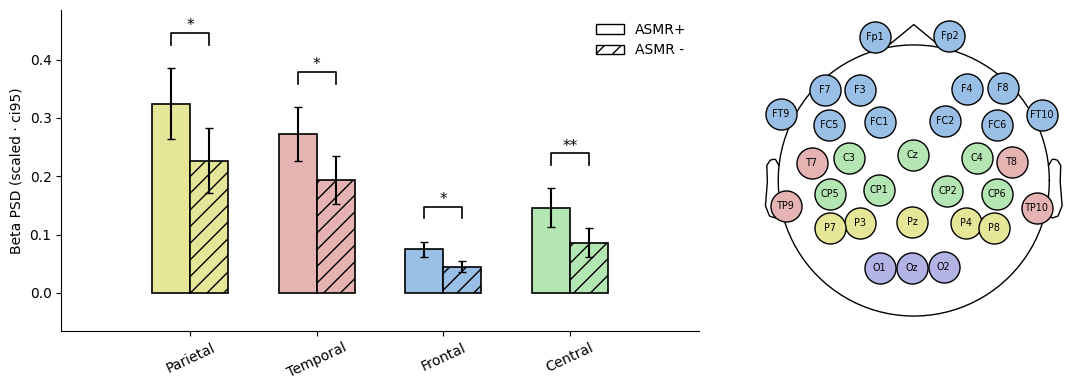

In [15]:
#NEW - PSD VERSION

import numpy as np, matplotlib.pyplot as plt, mne
from matplotlib.patches import Patch

# ───────── parameters ─────────
P_THRESH  = 0.05
ERR_KIND  = "ci95"          # "std" | "sem" | "ci95"
REGION_COLORS = {          # pastel palette
    "Frontal":   (0.60, 0.75, 0.90),
    "Central":   (0.70, 0.90, 0.70),
    "Temporal":  (0.90, 0.70, 0.70),
    "Parietal":  (0.90, 0.90, 0.60),
    "Occipital": (0.70, 0.70, 0.90),
    "Other":     (0.85, 0.85, 0.85, 0.15)
}

# ───────── helpers ─────────
def p_to_star(p):
    return "***" if p<=.001 else "**" if p<=0.01 else "*" if p<=.05 else ""

def err_bar(values):                       # values = list[np.array]
    if ERR_KIND == "std":
        return np.array([v.std(ddof=1) for v in values])
    if ERR_KIND == "sem":
        return np.array([v.std(ddof=1)/np.sqrt(len(v)) for v in values])
    if ERR_KIND == "ci95":
        return np.array([1.96*v.std(ddof=1)/np.sqrt(len(v)) for v in values])
    raise ValueError("ERR_KIND must be 'std', 'sem', or 'ci95'")

def draw_topomap_on_axis(epo, ax, s_size=4000):
    chs = epo.ch_names
    regs = {n:[i for i,ch in enumerate(chs) if ch.startswith(pref)]
            for n,pref in zip(["Frontal","Central","Temporal","Parietal","Occipital"],
                              ["F","C","T","P","O"])}
    regs["Other"] = np.setdiff1d(np.arange(len(chs)),
                                 np.concatenate(list(regs.values())))
    mne.viz.plot_sensors(epo.info, kind="topomap", ch_type="eeg",
                         axes=ax, show_names=False, show=False,
                         ch_groups=list(regs.values()))
    pos = ax.collections[0].get_offsets(); ax.collections[0].set_visible(False)
    for reg,idx in regs.items():
        if len(idx):
            ax.scatter(pos[idx,0], pos[idx,1], s=s_size, marker="o",
                       c=[REGION_COLORS[reg]], edgecolors="k",
                       linewidths=1.0, zorder=3 if reg!="Other" else 2)
    for i,name in enumerate(chs):
        ax.text(pos[i,0], pos[i,1], name, ha="center", va="center",
                fontsize="x-small", color="black", zorder=4)
    for sp in ax.spines.values(): sp.set_linewidth(1.3)

# ───────── data filter/load ─────────
sig_open = [r for r in all_results
            if r["Condition"]=="Closed" and r["p_corrected"]<P_THRESH]
by_band={}
for r in sig_open: by_band.setdefault(r["Band"],[]).append(r)

epochs = mne.read_epochs(
    "asmr_epochs/1-epochs-epo.fif",
    verbose=False, preload=False
)

# ───────── plotting ─────────
bands=list(by_band.keys()); n_bands=len(bands); mid=n_bands//2
fig,axes = plt.subplots(n_bands,2,figsize=(12,4*n_bands),
                        gridspec_kw=dict(width_ratios=[3,2]))
if n_bands==1: axes=axes[np.newaxis,:]

for i,band in enumerate(bands):
    res  = by_band[band]
    regs = [r["Region"] for r in res]
    vals_as=[np.asarray(r["ASMR_values"])    for r in res]
    vals_ct=[np.asarray(r["Control_values"]) for r in res]
    mean_as=np.array([v.mean() for v in vals_as])
    mean_ct=np.array([v.mean() for v in vals_ct])
    err_as,err_ct = err_bar(vals_as), err_bar(vals_ct)

    # 0-1 scaling per band
    vmin,vmax = np.hstack(vals_as+vals_ct).min(), np.hstack(vals_as+vals_ct).max()
    scale = vmax-vmin
    mean_as = (mean_as-vmin)/scale; mean_ct=(mean_ct-vmin)/scale
    err_as  = err_as/scale;        err_ct = err_ct/scale

    ax = axes[i,0]; x=np.arange(len(regs))*0.6; w=0.18
    cols=[REGION_COLORS[r] for r in regs]
    ax.bar(x-w/2, mean_as, w, yerr=err_as, capsize=3,
           color=cols, edgecolor='k', lw=1.2)
    ax.bar(x+w/2, mean_ct, w, yerr=err_ct, capsize=3,
           color=cols, edgecolor='k', lw=1.2, hatch='//')
    ax.set_xticks(x); ax.set_xticklabels(regs, rotation=25)
    ax.set_ylabel(f"{band} PSD (scaled · {ERR_KIND})")  # Changed from HFD to PSD
    ymin, ymax = (min(np.hstack([mean_as-err_as, mean_ct-err_ct])),
                  max(np.hstack([mean_as+err_as, mean_ct+err_ct])))
    ax.set_ylim(ymin - 0.1, ymax + 0.1)

    for j,p in enumerate([r["p_corrected"] for r in res]):
        star=p_to_star(p)
        if star:
            top=max(mean_as[j]+err_as[j], mean_ct[j]+err_ct[j])
            y=min(0.96, top+0.04)              # keep inside
            ax.plot([x[j]-w/2,x[j]-w/2,x[j]+w/2,x[j]+w/2],
                    [y,y+0.02,y+0.02,y],'k-',lw=1.2)
            ax.text(x[j], y+0.025, star, ha="center", fontsize=11)
    ax.spines[['top','right']].set_visible(False)
    ax.margins(x=0.2)
    ax.legend(handles=[
        Patch(facecolor='white', edgecolor='k', label='ASMR+'), 
        Patch(facecolor='white', edgecolor='k', hatch='//', label='ASMR -')
    ], frameon=False, loc='upper right')

    topo_ax=axes[i,1]
    topo_ax.axis("off")
    if i==mid: draw_topomap_on_axis(epochs, topo_ax, s_size=500)

plt.tight_layout(); fig.subplots_adjust(left=0.10)
fig.savefig("plots_psd/all_bands_with_single_topomap_psd.png", dpi=300)  # Changed save path and filename
plt.show()

In [16]:
"""
psd_stats_per_channel.py
────────────────────────
• Computes Power Spectral Density (PSD) for every single channel
  in ASMR vs. control data.
• Two‐sample Wilcoxon rank-sum tests (Closed-Eyes and Open-Eyes separately)
  are run per channel × band.
• Benjamini-Hochberg FDR correction is applied across **all**
  band × channel × condition comparisons.
• Significant tests (q < 0.10) are visualised as box-plots and saved
  to ./plots_psd, and their statistics are written to CSV.
"""
import os, numpy as np, mne, pandas as pd, matplotlib.pyplot as plt
from scipy.stats               import ttest_ind, ranksums
from scipy import signal
from statsmodels.stats.multitest import multipletests

# ───────────────────────────── parameters ────────────────────────────
freq_bands = {                       # modify if you wish
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta":  (12, 30),
    "Gamma": (30, 45)
}
N_SUBJECTS = None                    # set --> e.g. 10 to subsample

asmr_dir     = "./asmr_epochs"
control_dir  = "./control_epochs"
plot_dir     = "./plots_psd"
os.makedirs(plot_dir, exist_ok=True)

# Sampling rate (adjust if different)
sampling_rate = 250

# ───────────────────── helper: load raw data (no filtering) ───────────
def load_raw_data(folder, files):
    """Load raw epochs data without band-pass filtering for PSD computation"""
    closed, open_, ch_names = [], [], []
    for fn in files:
        ep = mne.read_epochs(os.path.join(folder, fn), verbose=False)
        ep.drop_channels([ch for ch in ("HOEG", "VEOG") if ch in ep.ch_names],
                         on_missing="ignore")
        # No filtering here - we'll compute PSD from raw data
        closed.append(ep["Closed Eyes"].get_data())
        open_.append(ep["Open Eyes"].get_data())
        ch_names = ep.ch_names                       # keep for later
    return (np.array(closed), np.array(open_), ch_names)

# ─────────────────────── helper: PSD per trial × channel ────────────
def psd_trials(data4d, fmin, fmax, fs=sampling_rate):
    """
    data4d shape: (n_subj, n_ep, n_ch, n_t)
    returns: ndarray (n_subj*n_ep, n_ch) with mean PSD in frequency band
    """
    flat = data4d.reshape(-1, data4d.shape[2], data4d.shape[3])
    out  = np.zeros((flat.shape[0], flat.shape[1]))
    
    for tr in range(flat.shape[0]):
        for ch in range(flat.shape[1]):
            # Compute PSD using Welch's method
            freqs, psd = signal.welch(
                flat[tr, ch, :],
                fs=fs,
                nperseg=min(256, flat.shape[2]),
                noverlap=None
            )
            
            # Find frequency indices for this band
            freq_mask = (freqs >= fmin) & (freqs <= fmax)
            
            # Calculate mean power in this band
            if np.any(freq_mask):
                band_power = np.mean(psd[freq_mask])
            else:
                band_power = 0.0
            
            out[tr, ch] = band_power
    
    return out

# ───────────────────────────── main loop ─────────────────────────────
asmr_files    = sorted(os.listdir(asmr_dir))
control_files = sorted(os.listdir(control_dir))

# Load raw data once
print("Loading raw data...")
as_cl_raw, as_op_raw, ch_names = load_raw_data(asmr_dir, asmr_files)
co_cl_raw, co_op_raw, _        = load_raw_data(control_dir, control_files)

if N_SUBJECTS:
    as_cl_raw, as_op_raw = as_cl_raw[:N_SUBJECTS], as_op_raw[:N_SUBJECTS]
    co_cl_raw, co_op_raw = co_cl_raw[:N_SUBJECTS], co_op_raw[:N_SUBJECTS]

all_tests, all_p = [], []

for band, (fmin, fmax) in freq_bands.items():
    print(f"\n=== {band}  {fmin}-{fmax} Hz ===")

    # Compute PSD for this frequency band
    as_cl_psd = psd_trials(as_cl_raw, fmin, fmax)
    as_op_psd = psd_trials(as_op_raw, fmin, fmax)
    co_cl_psd = psd_trials(co_cl_raw, fmin, fmax)
    co_op_psd = psd_trials(co_op_raw, fmin, fmax)

    # iterate over channels
    for ch_idx, ch in enumerate(ch_names):
        # Closed
        t_cl, p_cl = ranksums(as_cl_psd[:, ch_idx], co_cl_psd[:, ch_idx])
        df_cl = (len(as_cl_psd[:, ch_idx]) + len(co_cl_psd[:, ch_idx]) - 2)

        all_tests.append(dict(Band=band, Channel=ch, Condition="Closed",
                              t_stat=t_cl, df=df_cl,
                              p_uncorrected=p_cl,
                              ASMR=as_cl_psd[:, ch_idx],
                              Control=co_cl_psd[:, ch_idx]))
        all_p.append(p_cl)

        # Open
        t_op, p_op = ranksums(as_op_psd[:, ch_idx], co_op_psd[:, ch_idx])
        df_op = (len(as_op_psd[:, ch_idx]) + len(co_op_psd[:, ch_idx]) - 2)

        all_tests.append(dict(Band=band, Channel=ch, Condition="Open",
                              t_stat=t_op, df=df_op,
                              p_uncorrected=p_op,
                              ASMR=as_op_psd[:, ch_idx],
                              Control=co_op_psd[:, ch_idx]))
        all_p.append(p_op)

# ─────────────────────── FDR correction & annotation ─────────────────
rejected, p_corr, *_ = multipletests(all_p, method="fdr_bh")

for rec, q in zip(all_tests, p_corr):
    rec["p_corrected"] = q
    rec["Significant"] = bool(rec in [t for i,t in enumerate(all_tests) if rejected[i]])

# ───────────────────── helper: pretty box-plot ───────────────────────
def boxplot(asmr, ctrl, title, q, out_png):
    fig, ax = plt.subplots(figsize=(4.5, 5))
    bp = ax.boxplot([asmr, ctrl], positions=[1, 2], patch_artist=True,
                    showmeans=True, widths=.6)
    for patch, col in zip(bp["boxes"], ["#FFB347", "#9ACD32"]):
        patch.set_facecolor(col)
    for i, d in enumerate([asmr, ctrl]):
        ax.scatter(np.random.normal(1+i, .04, len(d)), d, color="k", alpha=.6, s=15)

    ax.set_xticks([1,2]); ax.set_xticklabels(["ASMR","Control"])
    ax.set_ylabel("PSD"); ax.set_title(title); ax.grid(True, ls=":")  # Changed from HFD to PSD
    # significance bar
    if q < .10:
        y = max(max(asmr), max(ctrl))*1.05
        ax.plot([1,1,2,2], [y,y*1.03,y*1.03,y], lw=1.2, c="k")
        stars = "***" if q<.001 else ("**" if q<.05 else "*")
        ax.text(1.5, y*1.03, stars, ha="center", va="bottom", fontsize=14)
    fig.tight_layout(); fig.savefig(out_png, dpi=300); plt.close(fig)

# ───────────────────────── plotting & CSV ────────────────────────────
sig_rows = []
for rec in all_tests:
    if rec["p_corrected"] < .10:
        fname = f"{plot_dir}/{rec['Condition']}_{rec['Band']}_{rec['Channel']}_PSD.png"  # Added _PSD suffix
        ttl   = (f"{rec['Channel']}  |  {rec['Band']}  |  "
                 f"{rec['Condition']} Eyes\nq = {rec['p_corrected']:.3f}")
        boxplot(rec["ASMR"], rec["Control"], ttl, rec["p_corrected"], fname)
        sig_rows.append(rec)

pd.DataFrame(sig_rows).to_csv(f"{plot_dir}/significant_pvalues_psd.csv", index=False)  # Changed filename
print(f"\n✓ Finished. {len(sig_rows)} tests survived FDR (q<0.10). "
      f"Plots & CSV saved to '{plot_dir}'")

Loading raw data...

=== Delta  1-4 Hz ===

=== Theta  4-8 Hz ===

=== Alpha  8-12 Hz ===

=== Beta  12-30 Hz ===

=== Gamma  30-45 Hz ===

✓ Finished. 50 tests survived FDR (q<0.10). Plots & CSV saved to './plots_psd'


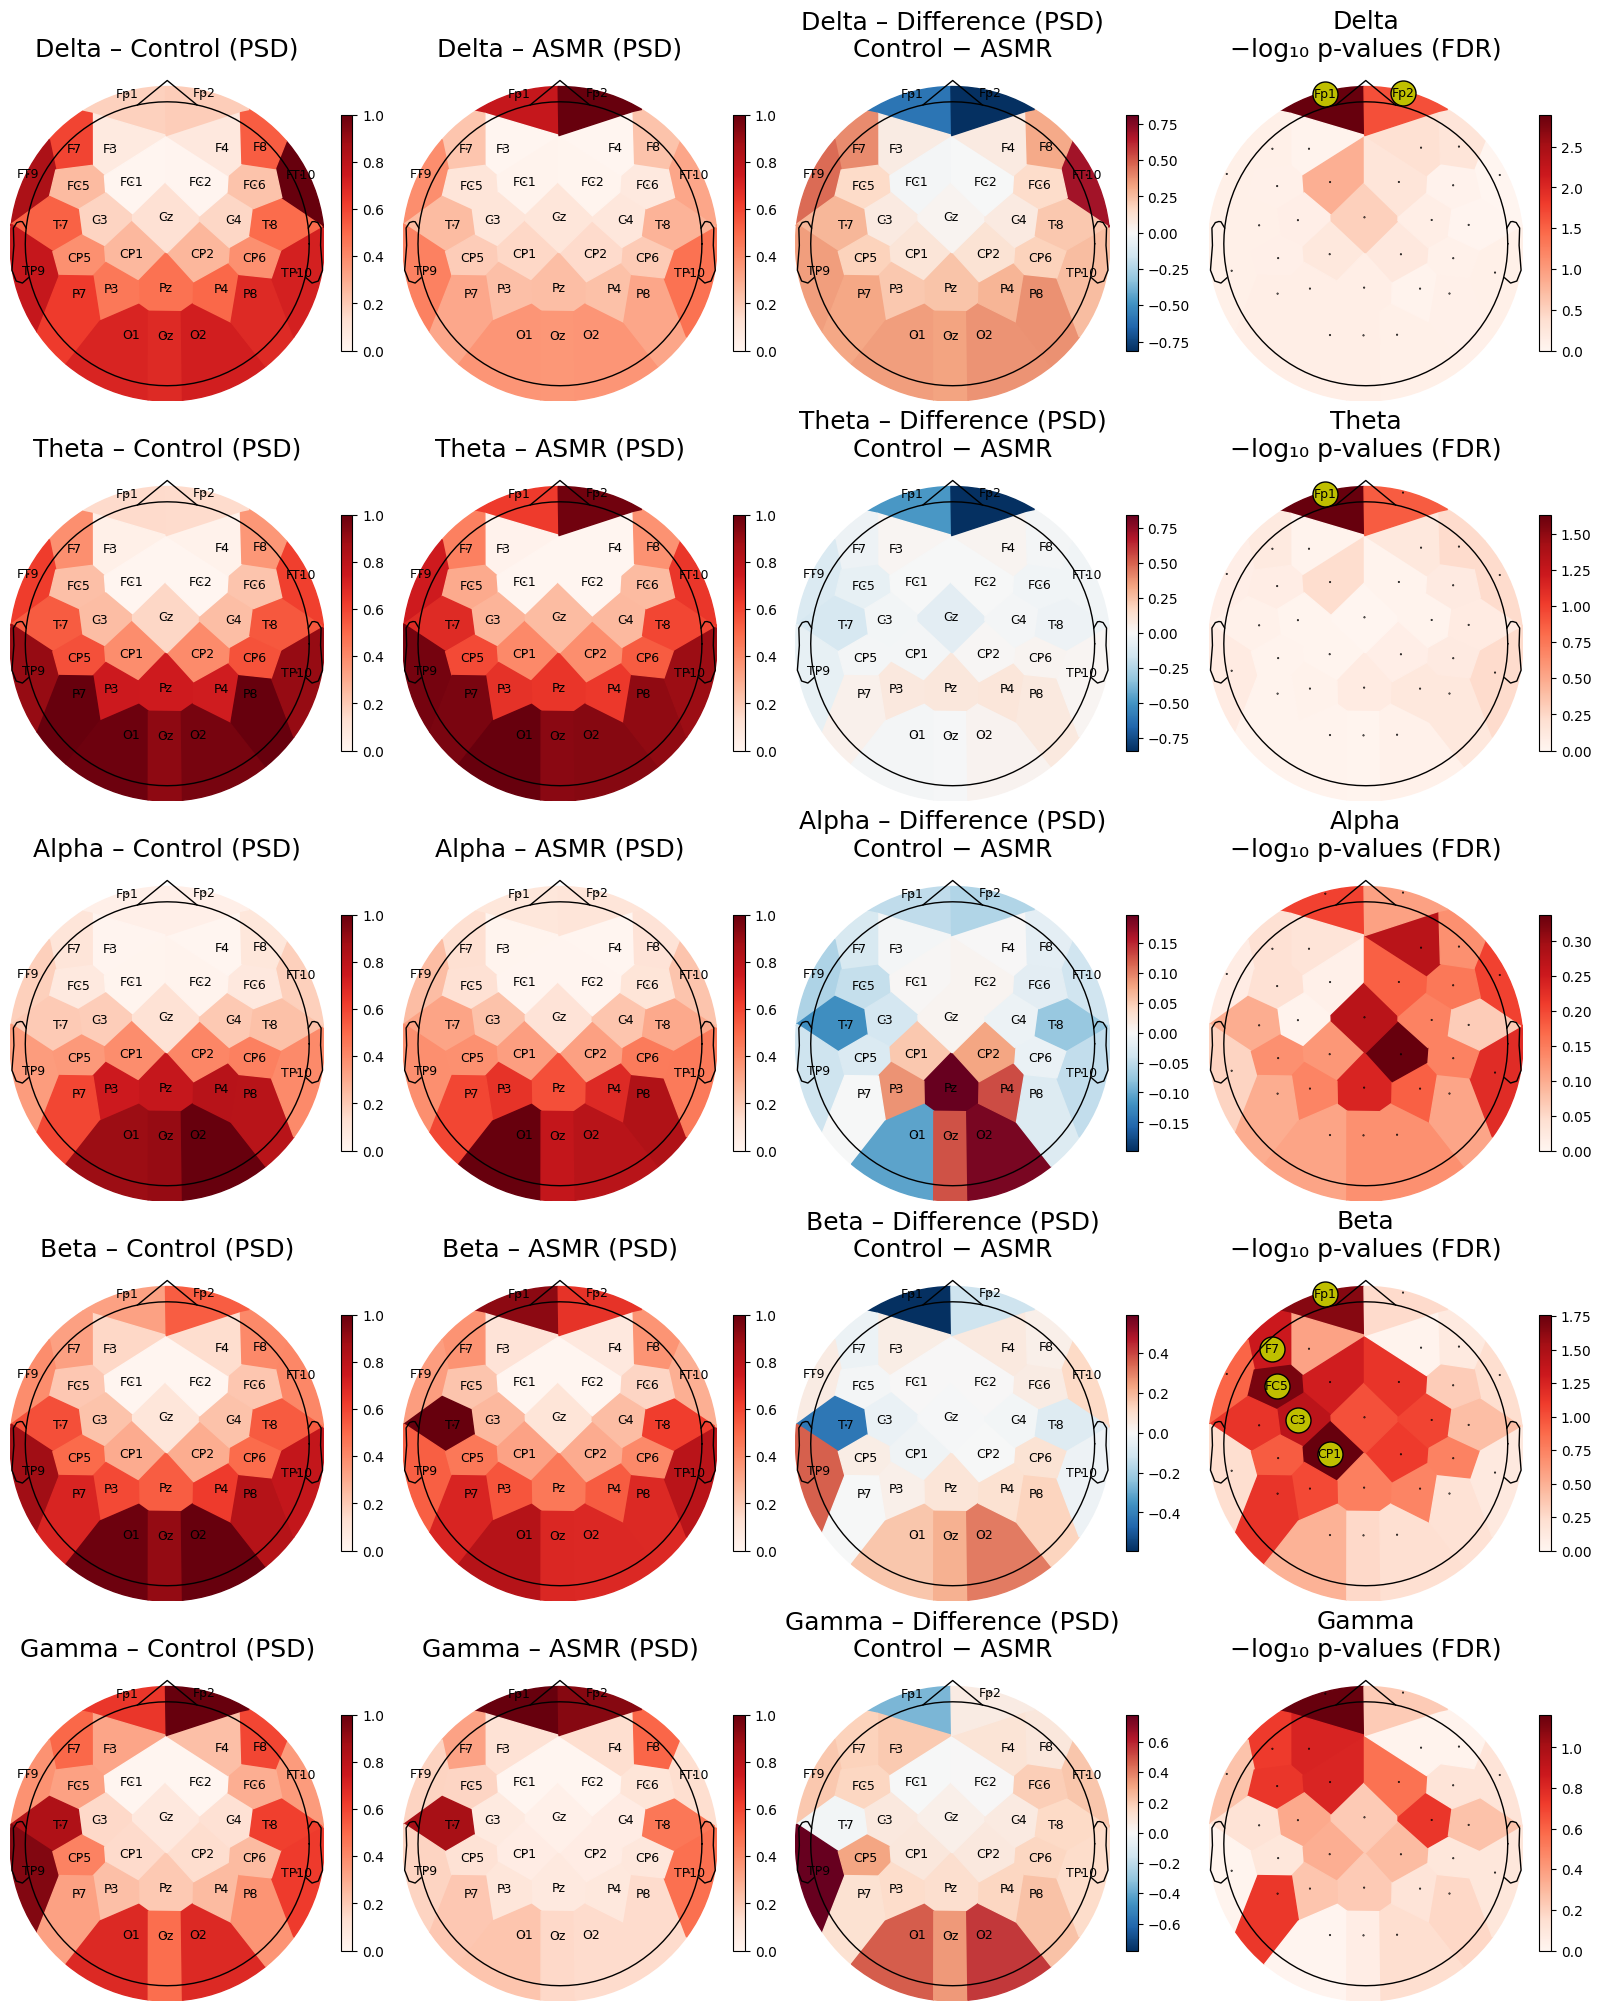

In [18]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from mne.viz import plot_topomap

# ───────────────────────────────────────────────────────────────
#  Assumes `all_tests` exists with p_corrected (FDR-adjusted) and
#  you have one epochs file to supply montage / info.
# ───────────────────────────────────────────────────────────────

open_tests = pd.DataFrame([rec for rec in all_tests if rec["Condition"] == "Open"])

# load an epochs file only for channel locations
epochs = mne.read_epochs(
    "asmr_epochs/1-epochs-epo.fif",
    verbose=False,
)

# use only the EEG sensors present in both the montage and the stats
picks_eeg = mne.pick_types(epochs.info, meg=False, eeg=True)
montage_order = [epochs.ch_names[i] for i in picks_eeg]

bands = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

fig, axes = plt.subplots(5, 4, figsize=(16, 20), constrained_layout=True)

for row, band in enumerate(bands):
    df_band = open_tests.query("Band == @band")

    # build DataFrame indexed by Channel, then align to montage order
    per_chan = (
        df_band.assign(
            mean_ASMR=lambda df: df["ASMR"].apply(np.mean),
            mean_Control=lambda df: df["Control"].apply(np.mean),
        )
        .set_index("Channel")
        .reindex(montage_order)         # ← alignment fix
        .dropna(subset=["mean_ASMR"])   # drop chans not present in stats
        .reset_index()
    )

    ch_names      = per_chan["Channel"].tolist()
    asmr_means    = per_chan["mean_ASMR"].to_numpy()
    control_means = per_chan["mean_Control"].to_numpy()
    pvals_corr    = per_chan["p_corrected"].to_numpy()
    sig_mask      = pvals_corr < 0.05

    # min–max normalisation per map
    asmr_norm    = (asmr_means - asmr_means.min()) / (asmr_means.max() - asmr_means.min())
    control_norm = (control_means - control_means.min()) / (control_means.max() - control_means.min())
    diff_norm    = control_norm - asmr_norm         # change sign if needed

    ax0, ax1, ax2, ax3 = axes[row]

    im0, _ = plot_topomap(control_norm, epochs.info, axes=ax0, show=False,
                          contours=0, names=ch_names, image_interp="nearest")
    ax0.set_title(f"{band} – Control (PSD)", fontsize=18)
    fig.colorbar(im0, ax=ax0, orientation="vertical", shrink=0.7)

    im1, _ = plot_topomap(asmr_norm, epochs.info, axes=ax1, show=False,
                          contours=0, names=ch_names, image_interp="nearest")
    ax1.set_title(f"{band} – ASMR (PSD)", fontsize=18)
    fig.colorbar(im1, ax=ax1, orientation="vertical", shrink=0.7)

    im2, _ = plot_topomap(diff_norm, epochs.info, axes=ax2, show=False,
                          contours=0, names=ch_names, cmap="RdBu_r", image_interp="nearest")
    ax2.set_title(f"{band} – Difference (PSD)\nControl − ASMR", fontsize=18)
    fig.colorbar(im2, ax=ax2, orientation="vertical", shrink=0.7)

    im3, _ = plot_topomap(-np.log10(pvals_corr), epochs.info, axes=ax3, show=False,
                          contours=0, names=ch_names, cmap="Reds",
                          mask=sig_mask, mask_params=dict(markersize=18,
                                                          markerfacecolor="y",
                                                          markeredgecolor="k",
                                                          linewidth=0),
                          image_interp="nearest")
    ax3.set_title(f"{band}\n−log₁₀ p-values (FDR)", fontsize=18)
    fig.colorbar(im3, ax=ax3, orientation="vertical", shrink=0.7)

# uniform label font size
for ax in axes.flat:
    for txt in ax.texts:
        txt.set_fontsize(9)

plt.show()
fig.savefig("plots_psd/all_bands_topomaps_psd_nearest.png", dpi=300)